<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 42.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb = self.label_embedding(labels)
        input = torch.cat((noise, label_emb), dim=1)
        out = self.model(input)
        return out


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_emb = self.label_embedding(labels)
        input = torch.cat((img, label_emb), dim=1)
        out = self.model(input)
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 100
label_dim = 10
img_dim = 28 * 28

G = Generator(noise_dim, label_dim, img_dim).to(device)
D = Discriminator(img_dim, label_dim).to(device)

criterion = nn.BCELoss()
optimizerG = optim.Adam(G.parameters(), lr=0.0002)
optimizerD = optim.Adam(D.parameters(), lr=0.0002)


In [ ]:
epochs = 50

for epoch in range(epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.size(0)
        imgs = imgs.view(batch_size, -1).to(device)
        labels = labels.to(device)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        ### Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_imgs = G(z, gen_labels)

        real_loss = criterion(D(imgs, labels), real)
        fake_loss = criterion(D(fake_imgs.detach(), gen_labels), fake)
        lossD = real_loss + fake_loss

        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        ### Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        gen_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_imgs = G(z, gen_labels)

        lossG = criterion(D(fake_imgs, gen_labels), real)

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {lossD.item():.4f} | Loss_G: {lossG.item():.4f}")


Epoch [1/50] | Loss_D: 0.1203 | Loss_G: 5.3241
Epoch [2/50] | Loss_D: 0.1124 | Loss_G: 5.4387
Epoch [3/50] | Loss_D: 0.1150 | Loss_G: 3.8984
Epoch [4/50] | Loss_D: 0.1368 | Loss_G: 3.9312
Epoch [5/50] | Loss_D: 0.2965 | Loss_G: 3.4625
Epoch [6/50] | Loss_D: 0.2871 | Loss_G: 4.4803
Epoch [7/50] | Loss_D: 0.0923 | Loss_G: 4.8182
Epoch [8/50] | Loss_D: 0.4495 | Loss_G: 4.3637
Epoch [9/50] | Loss_D: 0.3169 | Loss_G: 4.6912
Epoch [10/50] | Loss_D: 0.4004 | Loss_G: 4.2196
Epoch [11/50] | Loss_D: 0.2412 | Loss_G: 4.1396
Epoch [12/50] | Loss_D: 0.2097 | Loss_G: 5.3873
Epoch [13/50] | Loss_D: 0.2471 | Loss_G: 3.6882
Epoch [14/50] | Loss_D: 0.3900 | Loss_G: 3.6388
Epoch [15/50] | Loss_D: 0.2452 | Loss_G: 4.2841
Epoch [16/50] | Loss_D: 0.2640 | Loss_G: 4.5664
Epoch [17/50] | Loss_D: 0.2824 | Loss_G: 4.1651
Epoch [18/50] | Loss_D: 0.3407 | Loss_G: 3.4946
Epoch [19/50] | Loss_D: 0.1477 | Loss_G: 5.5958
Epoch [20/50] | Loss_D: 0.1965 | Loss_G: 5.2354
Epoch [21/50] | Loss_D: 0.1365 | Loss_G: 4.8410
E

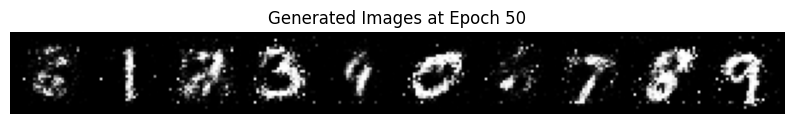

In [ ]:
def show_generated_images(generator, epoch):
    z = torch.randn(10, noise_dim).to(device)
    labels = torch.arange(0, 10).to(device)
    generated = generator(z, labels).detach().cpu()
    generated = generated.view(-1, 1, 28, 28)

    grid = torchvision.utils.make_grid(generated, nrow=10, normalize=True)
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.axis('off')
    plt.show()

show_generated_images(G, epoch+1)
